In [1]:
IMAGE_SIZE=[512, 1280]

POSITIVE_KolektorSDD=[['5'], ['6'], ['2'], ['3'], ['5'], ['7'], ['1'], ['2'], ['6'], ['3'],
					  ['4'], ['5'], ['3'], ['7'], ['3'], ['5'], ['5'], ['3'], ['5'], ['4'],
				  	  ['5'], ['6'], ['6'], ['1'], ['4'], ['5'], ['0'], ['3'], ['0'], ['0'],
				 	  ['1'], ['2'], ['6'], ['0'], ['5'], ['3'], ['0'], ['0', '1'], ['6', '7'],['5'],
					  ['7'], ['3'], ['1'], ['6'], ['3'], ['7'], ['2'], ['5',], ['2'],['4']]

DATA_DIR = './KolektorSDD'

model_folder = './segmentation_model_file'
csv_file = './segmentation_log_file.csv'

decision_model_folder = './decision_model_file'
decision_csv_file = './decision_log_file.csv'

In [2]:
import re
import os
import numpy as np
import cv2
from random import shuffle
import tensorflow as tf
from tensorflow import keras
from keras.models import *
from keras.callbacks import *
from keras.optimizers import SGD
from keras.utils import img_to_array
from keras.optimizers import Adam
from keras import regularizers
from keras.layers import *
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from PIL import Image
import shutil

# Data Preprocessing:

Reading and Splitting data

In [3]:
def listData(data_dir, mode, test_ratio=0.2, positive_index=POSITIVE_KolektorSDD):
		""" this function is designed for the Dataset of KolektorSDD,
			the positive samples and negative samples will be divided into two lists
		:param  data_dir:  the  data folder   of KolektorSDD
		:param  test_ratio: the proportion of test set
		:param positive_index:   the  list  of  index of   every subfolders' positive samples
		:return:    the list of  the positive samples and the list of negative samples
		"""
		example_dirs = [x[1] for x in os.walk(data_dir)][0]
		example_lists = {os.path.basename(x[0]): x[2] for x in os.walk(data_dir)}
		train_test_offset=np.floor(len(example_lists)*(1-test_ratio))
		Positive_examples_train = []
		Negative_examples_train = []
		Positive_examples_valid = []
		Negative_examples_valid = []
		for i in range(len(example_dirs)):
			example_dir = example_dirs[i]
			example_list = example_lists[example_dir]
			# 过滤label图片
			example_list = [item for item in example_list if "label" not in item]
			# 训练数据
			if i < train_test_offset:
				for j in range(len(example_list)):
					example_image = example_dir + '/' + example_list[j]
					example_label = example_image.split(".")[0] + "_label.bmp"
					# 判断是否是正样本
					index = example_list[j].split(".")[0][-1]
					if index in positive_index[i]:
						Positive_examples_train.append([example_image, example_label])
					else:
						Negative_examples_train.append([example_image, example_label])
			else:
				for j in range(len(example_list)):
					example_image = example_dir + '/' + example_list[j]
					example_label = example_image.split(".")[0] + "_label.bmp"
					index=example_list[j].split(".")[0][-1]
					if index in positive_index[i]:
						Positive_examples_valid.append([example_image, example_label])
					else:
						Negative_examples_valid.append([example_image, example_label])
		if mode == "training":
			return Positive_examples_train,Negative_examples_train
		if mode == "testing":
			return Positive_examples_valid,Negative_examples_valid

Preprocessing the images and making data generator out of them

In [4]:
def generator(data_dir, positive_data_list, negative_data_list, batch_size, input_shape, mode):
    
    num_positive_samples = len(positive_data_list)
    num_negative_samples = len(negative_data_list)
    positive_indices = np.arange(num_positive_samples)
    negative_indices = np.arange(num_negative_samples)
    
    while True:
        
        np.random.shuffle(positive_indices)
        np.random.shuffle(negative_indices)
        
        for i in range(0, num_positive_samples, batch_size):
            
            positive_batch_indices = positive_indices[i:i+batch_size]
            negative_batch_indices = negative_indices[i:i+batch_size]
            positive_batch_data = [positive_data_list[j] for j in positive_batch_indices]
            negative_batch_data = [negative_data_list[j] for j in negative_batch_indices]

            batch_images = []
            batch_labels_pixel = []
            batch_labels = []
            batch_filenames = []
            
            for file_basename_image, file_basename_label in positive_batch_data:
                
                image_path = os.path.join(data_dir, file_basename_image)
                label_path = os.path.join(data_dir, file_basename_label)

                image = load_and_preprocess_image(image_path, input_shape)
                label_pixel, label = load_and_preprocess_mask(label_path, input_shape)

                batch_images.append(image)
                batch_labels_pixel.append(label_pixel)
                batch_labels.append(label)
                batch_filenames.append(file_basename_image)

            for file_basename_image, file_basename_label in negative_batch_data:
                
                image_path = os.path.join(data_dir, file_basename_image)
                label_path = os.path.join(data_dir, file_basename_label)

                image = load_and_preprocess_image(image_path, input_shape)
                label_pixel, label = load_and_preprocess_mask(label_path, input_shape)

                batch_images.append(image)
                batch_labels_pixel.append(label_pixel)
                batch_labels.append(label)
                batch_filenames.append(file_basename_image)
                
            batch_images = np.array(batch_images)
            batch_labels_pixel = np.array(batch_labels_pixel)
            batch_labels = np.array(batch_labels)

            if mode == "Segmentation":
                yield batch_images, batch_labels_pixel
            
            elif mode == "Decision":
                yield batch_images, batch_labels
                
        
def load_and_preprocess_image(image_path, input_shape):
    
    image = cv2.imread(image_path, 0)

    image = cv2.resize(image, input_shape)

    image = img_to_array(image)
    

    return image


def load_and_preprocess_mask(mask_path, input_shape):
    
    mask = cv2.imread(mask_path, 0)
    
    mask = cv2.resize(mask, (int(input_shape[0]/8), int(input_shape[1]/8)))

    label_pixel = ImageBinarization(mask)
    
    label= mask.sum()
    
    if label>0:
        label=1
        
    return label_pixel, label 


def ImageBinarization(img, threshold=1):
    
    img = img_to_array(img)
    
    image = np.where(img > threshold, 1, 0)
    
    return image

In [5]:
positive_train_data_list, negative_train_data_list= listData('.\KolektorSDD', 'training')
positive_val_data_list, negative_val_data_list= listData('.\KolektorSDD', 'testing')

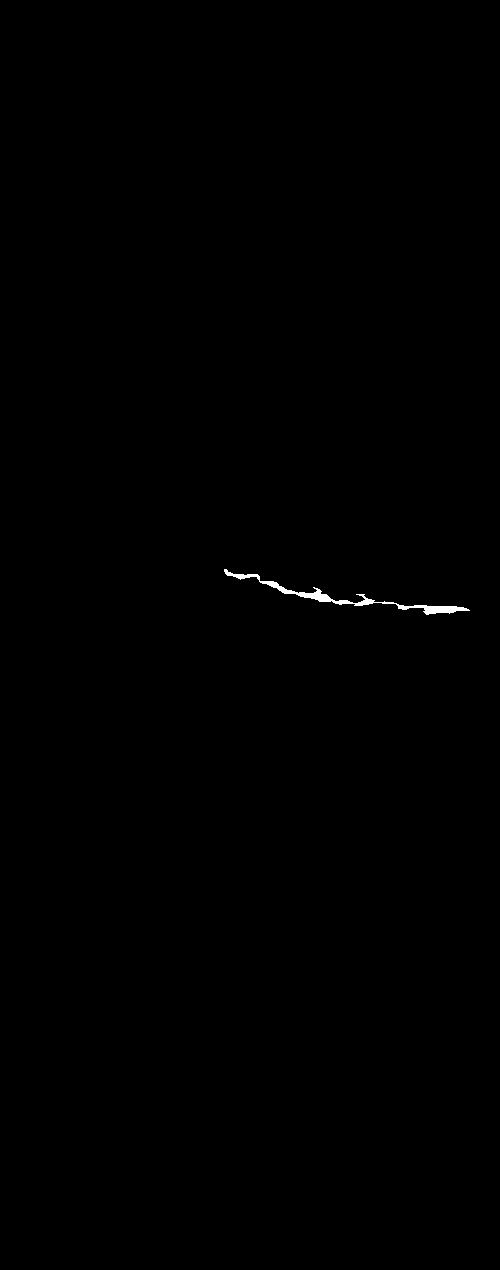

In [6]:
Image.open('E:/DefectDetectionKolektor/KolektorSDD/' + str(positive_train_data_list[0][1]))

In [6]:
train_generator = generator(DATA_DIR, 
                            positive_train_data_list, 
                            negative_train_data_list, 
                            batch_size=1, 
                            input_shape= IMAGE_SIZE, 
                            mode = "Segmentation")

val_generator = generator(DATA_DIR, 
                          positive_val_data_list, 
                          negative_val_data_list, 
                          batch_size=1, 
                          input_shape= IMAGE_SIZE, 
                          mode = "Segmentation")

In [7]:
d_train_generator = generator(DATA_DIR, 
                              positive_train_data_list, 
                              negative_train_data_list, 
                              batch_size=1, 
                              input_shape= IMAGE_SIZE, 
                              mode = "Decision")

d_val_generator = generator(DATA_DIR, 
                            positive_val_data_list, 
                            negative_val_data_list, 
                            batch_size=1, 
                            input_shape= IMAGE_SIZE, 
                            mode = "Decision")

# Model

In [11]:
def conv_block(input, num_filters, kernel_size, padding = "same"):
    
    conv = Conv2D(num_filters, kernel_size, padding = padding)(input)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    
    return conv

Segmentation layers

In [12]:
def SegmentationNet(input):
        
    net = conv_block(input, 32, (5,5))
    net = conv_block(net, 32, (5,5))
    net = MaxPool2D((2,2), (2,2))(net)
        
    net = conv_block(net, 64, (5,5))
    net = conv_block(net, 64, (5,5))
    net = conv_block(net, 64, (5,5))
    net = MaxPool2D((2,2), (2,2))(net)
        
    net = conv_block(net, 64, (5,5))
    net = conv_block(net, 64, (5,5))
    net = conv_block(net, 64, (5,5))
    net = conv_block(net, 64, (5,5))
    net = MaxPool2D((2,2),(2,2))(net)
        
    net = conv_block(net, 1024, (15,15))
        
    features = net
        
    net = Conv2D(1, (1,1), padding= "same")(net)
        
    logits_pixel =  net
        
    mask = Activation('sigmoid')(net)
            
    return features,logits_pixel,mask

Decision layers

In [36]:
def DecisionNet(loaded_model):

    features = loaded_model.get_layer("activation_9").output
    mask = loaded_model.get_layer("activation_10").output

    net = Concatenate(axis=-1, name='concat_features_mask')([features, mask])

    net = Conv2D(8, (5, 5), padding="same", name='conv_1')(net)
    net = MaxPool2D((2, 2), (2, 2), name='maxpool10')(net)

    net = Conv2D(16, (5, 5), padding="same", name='conv_2')(net)
    net = MaxPool2D((2, 2), (2, 2), name='maxpool20')(net)

    net = Conv2D(32, (5, 5), name='conv_3')(net)
    net = MaxPool2D((2, 2), (2, 2), name='maxpool30')(net)

    vector1 = GlobalAveragePooling2D(name='global_avg_pool1')(net)
    vector2 = GlobalMaxPooling2D(name='global_max_pool1')(net)
    vector3 = GlobalAveragePooling2D(name='global_avg_pool2')(mask)
    vector4 = GlobalMaxPooling2D(name='global_max_pool2')(mask)

    net = Concatenate(axis=1, name='concat_vectors')([vector2, vector1, vector3, vector4])

    output = Dense(1, activation='sigmoid', name='output')(net)
    #output = Dense(1,name='output')(net)
    
    return output


# def DecisionNet(loaded_model):

#     features = loaded_model.get_layer("activation_9").output
#     mask = loaded_model.get_layer("activation_10").output

#     net = Concatenate(axis=-1, name='concat_features_mask')([features, mask])

#     net = Conv2D(8, (5, 5), padding="same", name='conv_1', kernel_regularizer=regularizers.l2(0.001))(net)
#     net = MaxPool2D((2, 2), (2, 2), name='maxpool10')(net)
#     net = Dropout(0.2)(net)

#     net = Conv2D(16, (5, 5), padding="same", name='conv_2', kernel_regularizer=regularizers.l2(0.001))(net)
#     net = MaxPool2D((2, 2), (2, 2), name='maxpool20')(net)
#     net = Dropout(0.2)(net)

#     net = Conv2D(32, (5, 5), name='conv_3', kernel_regularizer=regularizers.l2(0.001))(net)
#     net = MaxPool2D((2, 2), (2, 2), name='maxpool30')(net)
#     net = Dropout(0.2)(net)

#     vector1 = GlobalAveragePooling2D(name='global_avg_pool1')(net)
#     vector2 = GlobalMaxPooling2D(name='global_max_pool1')(net)
#     vector3 = GlobalAveragePooling2D(name='global_avg_pool2')(mask)
#     vector4 = GlobalMaxPooling2D(name='global_max_pool2')(mask)

#     net = Concatenate(axis=1, name='concat_vectors')([vector2, vector1, vector3, vector4])

#     output = Dense(1, name='output')(net)
#     #output = Dense(1, activation= "sigmoid",name='output')(net)

#     return output

Loss functions:

In [9]:
def sigmoid_cross_entropy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels= y_true, logits= y_pred))

# Create and compile segementation model:

In [ ]:
def define_and_compile_seg_model():
    
    input_tensor = Input(shape=(1280, 512, 1))
    
    features, logits_pixel, mask = SegmentationNet(input_tensor)
    
    segmentation_model = Model(inputs=input_tensor, outputs=[features, logits_pixel, mask], name = "Segmentation")
    
    optimizer = SGD(learning_rate= 0.1, momentum=0.0)

    segmentation_model.compile(optimizer=optimizer, loss=[None, sigmoid_cross_entropy, None])
    
    return segmentation_model

In [ ]:
segmentation_model = define_and_compile_seg_model()
segmentation_model.summary()

In [19]:
callbacks = [
    ModelCheckpoint(model_folder, verbose = 1, save_best_only = True),
    CSVLogger(csv_file),
]

In [ ]:
# Train SegmentationNet
segmentation_model.fit(train_generator, 
                       validation_data= val_generator,
                       epochs=100, 
                       batch_size=1, 
                       steps_per_epoch = len(positive_train_data_list),
                       validation_steps= len(positive_val_data_list),
                       callbacks= callbacks)

# Create and compile decision model:

In [10]:
custom_objects = {'sigmoid_cross_entropy': sigmoid_cross_entropy}

loaded_model = load_model('./segmentation_model_file', custom_objects=custom_objects)

loaded_model.trainable = False

In [14]:
c = 0
for batch_image, batch_label_pixel in val_generator:
    c+=1 
    nvm1,nvm2,mask = loaded_model.predict(batch_image)
    if c > 0:
        break

1/1 [==============================] - 0s 8ms/step


In [16]:
data_reshaped = batch_image.reshape((2, 1280, 512))

image = np.uint8(data_reshaped[0] * 255)

cv2.imshow('Image', image)
cv2.destroyAllWindows()

cv2.imwrite('image.png', image)

True

In [15]:
data_reshaped = mask.reshape((2, 160, 64))

image = np.uint8(data_reshaped[0] * 255)

cv2.imshow('Image', image)
cv2.destroyAllWindows()

cv2.imwrite('mask.png', image)

True

In [37]:
def define_and_compile_decision_model(loaded_model):
    
    decision_output = DecisionNet(loaded_model)
    
    input_tensor = loaded_model.input
    
    decision_model = Model(inputs=input_tensor, 
                           outputs=decision_output, 
                           name = "Decision")
    
    # optimizer = SGD(learning_rate= 0.0005)
    # decision_model.compile(optimizer=optimizer, loss = sigmoid_cross_entropy, metrics = ['accuracy'])
    decision_model.compile(optimizer=Adam(learning_rate=0.0005), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return decision_model

In [38]:
decision_model = define_and_compile_decision_model(loaded_model)

In [39]:
# decision_callbacks = [
#     ModelCheckpoint(decision_model_folder, verbose = 1, save_best_only = True),
#     CSVLogger(decision_csv_file),
# ]

decision_callbacks = [
    ModelCheckpoint('./decision_model_SGD_file', verbose = 1, save_best_only = True),
    #ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 2),
    CSVLogger('./decision_SGD_log_file'),
]




In [ ]:
decision_model.fit(d_train_generator,
                  validation_data= d_val_generator,
                  epochs=100,
                  batch_size=1,
                  steps_per_epoch = len(positive_train_data_list),
                  validation_steps= len(positive_val_data_list),
                  callbacks = decision_callbacks)

# Testing and evaluating the model and visualizing the results:

In [73]:
load_decision = load_model('./decision_model_Adam_file')

# custom_objects = {'sigmoid_cross_entropy': sigmoid_cross_entropy}

# load_decision = load_model('E:\DefectDetectionKolektor\decision_model_SGD_reg&drop_file', custom_objects = custom_objects)

In [43]:
load_decision.summary()

Model: "Decision"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1280, 512,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 1280, 512, 3  832         ['input_1[0][0]']                
                                2)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1280, 512, 3  128        ['conv2d[0][0]']                 
 alization)                     2)                                                         

In [74]:
def test(model, test_data_loader):
    
    confusion_matrix = np.zeros((2, 2))
    count = 0

    for images, labels in test_data_loader:

        if count >= 20:
            break
        
        predictions = model.predict(images)

        for i in range(len(labels)):
            count+=1
            if labels[i] == 1 and predictions[i] > 0.5:
                confusion_matrix[0, 0] += 1  # True Positive
            elif labels[i] == 1:
                confusion_matrix[0, 1] += 1  # False Negative
            elif predictions[i] > 0.5:
                confusion_matrix[1, 0] += 1  # False Positive
            else:
                confusion_matrix[1, 1] += 1  # True Negative

    accuracy = (confusion_matrix[0, 0] + confusion_matrix[1, 1]) / np.sum(confusion_matrix)
    precision = confusion_matrix[0, 0] / (confusion_matrix[0, 0] + confusion_matrix[1, 0])
    recall = confusion_matrix[0, 0] / (confusion_matrix[0, 0] + confusion_matrix[0, 1])
  
    return confusion_matrix, accuracy, precision, recall
    

In [75]:
confusion_matrix, accuracy, precision, recall = test(load_decision, d_val_generator)

1/1 [==============================] - 0s 21ms/step


In [45]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

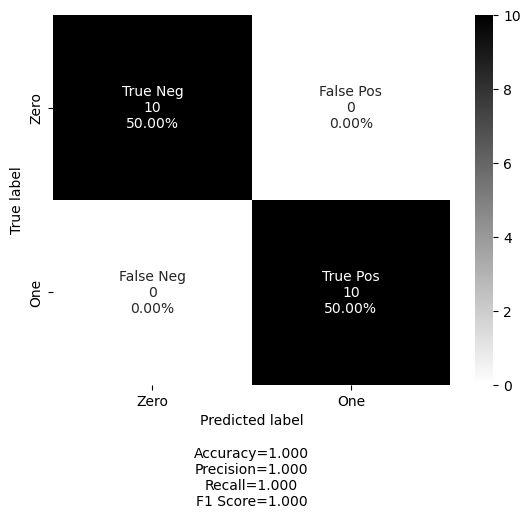

In [76]:
labels = ['True Neg','False Pos','False Neg','True Pos']

categories = ['Zero', 'One']
make_confusion_matrix(confusion_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap= 'binary')

In [ ]:
# def DecisionNet(loaded_model):

#     features = loaded_model.get_layer("activation_9").output
#     mask = loaded_model.get_layer("activation_10").output

#     net = Concatenate(axis=-1, name='concat_features_mask')([features, mask])

#     net = Conv2D(8, (5, 5), padding="same", name='conv_1', kernel_regularizer=regularizers.l2(0.001))(net)
#     net = MaxPool2D((2, 2), (2, 2), name='maxpool10')(net)
#     net = Dropout(0.2)(net)

#     net = Conv2D(16, (5, 5), padding="same", name='conv_2', kernel_regularizer=regularizers.l2(0.001))(net)
#     net = MaxPool2D((2, 2), (2, 2), name='maxpool20')(net)
#     net = Dropout(0.2)(net)

#     net = Conv2D(32, (5, 5), name='conv_3', kernel_regularizer=regularizers.l2(0.001))(net)
#     net = MaxPool2D((2, 2), (2, 2), name='maxpool30')(net)
#     net = Dropout(0.2)(net)

#     vector1 = GlobalAveragePooling2D(name='global_avg_pool1')(net)
#     vector2 = GlobalMaxPooling2D(name='global_max_pool1')(net)
#     vector3 = GlobalAveragePooling2D(name='global_avg_pool2')(mask)
#     vector4 = GlobalMaxPooling2D(name='global_max_pool2')(mask)

#     net = Concatenate(axis=1, name='concat_vectors')([vector2, vector1, vector3, vector4])

#     output = Dense(1, activation='sigmoid', name='output')(net)

#     return output






# def DecisionNet(loaded_model):

#     features = loaded_model.get_layer("activation_9").output
#     mask = loaded_model.get_layer("activation_10").output

#     net = Concatenate(axis=-1, name='concat_features_mask')([features, mask])

#     net = Conv2D(8, (5, 5), padding="same", name='conv_1', kernel_regularizer=regularizers.l2(0.001))(net)
#     net = MaxPool2D((2, 2), (2, 2), name='maxpool10')(net)
#     #net = Dropout(0.2)(net)

#     net = Conv2D(16, (5, 5), padding="same", name='conv_2', kernel_regularizer=regularizers.l2(0.001))(net)
#     net = MaxPool2D((2, 2), (2, 2), name='maxpool20')(net)
#     #net = Dropout(0.2)(net)

#     net = Conv2D(32, (5, 5), name='conv_3', kernel_regularizer=regularizers.l2(0.001))(net)
#     net = MaxPool2D((2, 2), (2, 2), name='maxpool30')(net)
#     #net = Dropout(0.2)(net)

#     vector1 = GlobalAveragePooling2D(name='global_avg_pool1')(net)
#     vector2 = GlobalMaxPooling2D(name='global_max_pool1')(net)
#     vector3 = GlobalAveragePooling2D(name='global_avg_pool2')(mask)
#     vector4 = GlobalMaxPooling2D(name='global_max_pool2')(mask)

#     net = Concatenate(axis=1, name='concat_vectors')([vector2, vector1, vector3, vector4])

#     #output = Dense(1, name='output')(net)
#     output = Dense(1, activation= "sigmoid",name='output')(net)

#     return output

